In [4]:
from pymed import PubMed

import numpy as np
import pandas as pd

import json

#### The first is defining our webscraping function. This utulizes the PubMed library allowing for easy webscraping capability. We also use the json libarry to convert the returned JSON object from Pubmed into a Pandas dataframe.

In [5]:
# Input: List of Keywords [], an int representing the max number
# Output: The dataframe that consists of the aggregation of data
def retrieve_data(list_keywords, max_result):
    pubmed = PubMed(tool="MyTool", email="ethango1997@gmal.com")
    data = pd.DataFrame({
        'Title': [],
        'Abstract': [],
        'Publication Date': []
        })    
    for keyword in list_keywords:
        results = pubmed.query("cancer", max_results=max_result)
        title = []
        abstract = []
        publication = []
        for article in results:
            json_format = json.loads(article.toJSON()) 
            title.append(json_format['title'])
            abstract.append(json_format['abstract'])
            publication.append(json_format['publication_date'])
        title = np.array(title)
        abstract = np.array(abstract)
        temp = pd.DataFrame({
            'Title': title,
            'Abstract': abstract,
            'Publication Date': publication
        })
        data = pd.concat([data, temp])
    return data

In [6]:
keywords = ['Obesity', 'Cancer', 'Covid-19', 'Wearable', 'mental health', 'influenze']
max_words = 100

In [7]:
data = retrieve_data(keywords, max_words)

In [8]:
data['Publication Date'].value_counts()

2020-12-06    600
Name: Publication Date, dtype: int64

#### Analysis of dataframe

#### MAIN QUESTION: How can NLP be used to identify relevant keywords in some articles that does not exist in others

In [9]:
data['Abstract'] = data['Abstract'].astype(str)

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = data['Abstract'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
tokenized_doc = tokenized_doc.tolist()
for i in range(len(data)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

data['Abstract'] = detokenized_doc

In [27]:
# tokenization
tokenized_doc = data['Title'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
tokenized_doc = tokenized_doc.tolist()
for i in range(len(data)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

data['Title'] = detokenized_doc

In [11]:
data.Abstract

0     Ovarian cancer one three major malignancies fe...
1     Internal rectal prolapse (IRP) bewildering con...
2                                                  None
3     Disease surveillance coronary artery disease c...
4     Haemophilia B (HB) less well studied haemophil...
                            ...                        
95                                                 None
96    To determine optimal dose-volume constraint la...
97    Lamellar ichthyosis (LI) genetic skin disorder...
98    Healthcare potent emitter greenhouse gases amo...
99                                                 None
Name: Abstract, Length: 600, dtype: object

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


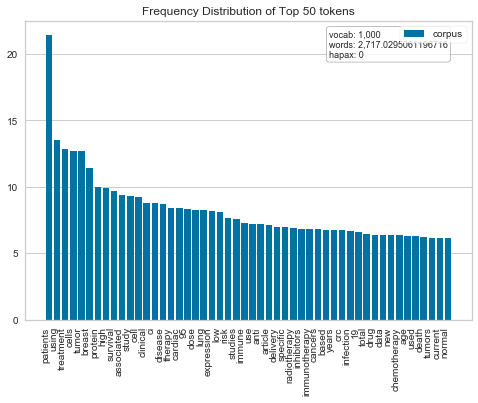

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer

# Load the text data
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)
X = vectorizer.fit_transform(data.Abstract)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(X)
visualizer.show()

In [13]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [14]:
# get list of terms
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
patients
tumor
treatment
cells
breast
survival
high
 
Topic 1: 
tumor
cells
delivery
drug
cell
immunotherapy
icd
 
Topic 2: 
protein
breast
infection
er
myeloid
mutations
variants
 
Topic 3: 
cardiac
prrt
covid
19
infection
disease
radiotherapy
 
Topic 4: 
cardiac
protein
breast
er
women
prrt
receptor
 
Topic 5: 
cardiac
implant
ci
protein
95
implants
dose
 
Topic 6: 
protein
expression
dose
cysteine
19
melanoma
covid
 
Topic 7: 
using
crc
protein
cd274
assessment
fungal
cases
 
Topic 8: 
crc
cd274
fungal
pd
vs
mmp
survival
 
Topic 9: 
using
implant
implants
correction
cases
bone
hematopoietic
 


### Using Spacy to analyze sentiment

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
for abstract in data.Abstract:
    doc = nlp(abstract)
    # Tokenization
    token_list = [token for token in doc]
    # Removing Stop Words
    filtered_tokens = [token for token in doc if not token.is_stop]

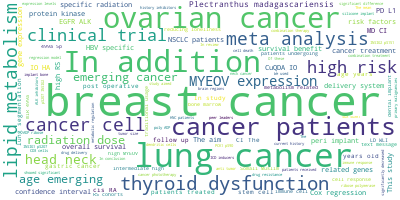

In [21]:
from wordcloud import WordCloud


# Join the different processed titles together.
long_string = ','.join(list(data['Abstract'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Association Rule Mining

In [22]:
from prefixspan import PrefixSpan

def convert(lst): 
    return (lst.split()) 

In [31]:
list_title_pre = []

for item in data.Title:
    list_item = convert(item)
    list_title_pre.append(list_item)
    
ps = PrefixSpan(list_title_pre)
print(ps.frequent(20))

[(102, ['cancer']), (66, ['A']), (48, ['breast']), (24, ['breast', 'cancer']), (30, ['treatment']), (30, ['An']), (24, ['Treatment']), (24, ['Results']), (24, ['advanced']), (24, ['Prognostic']), (30, ['immune']), (24, ['tumor']), (42, ['Cancer']), (24, ['review']), (24, ['inhibitors']), (24, ['gastric']), (48, ['patients']), (36, ['cell']), (36, ['lung']), (54, ['cancer.']), (24, ['Response']), (24, ['Comment'])]


In [34]:
from efficient_apriori import apriori

list_title = []

def convert(lst): 
    return (lst.split()) 

for item in data.Title:
    list_item = convert(item)
    list_title.append(tuple(list_item))

In [37]:
itemsets, rules = apriori(list_title, min_support=0.05,min_confidence=0.8)
print(rules) 

[]


In [38]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=2)
ipca.fit(X)
IncrementalPCA(n_components=2)
array = ipca.transform(X)

In [40]:
import matplotlib.pyplot as plt

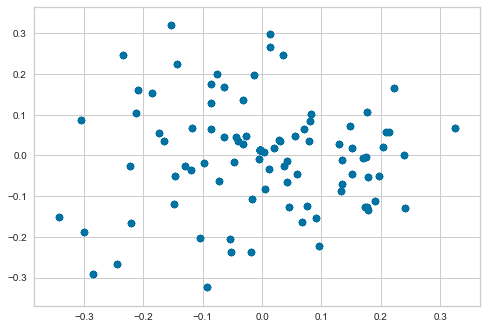

In [53]:
plt.scatter(array[:,0], array[:,1])

In [65]:
X

<600x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 26658 stored elements in Compressed Sparse Row format>

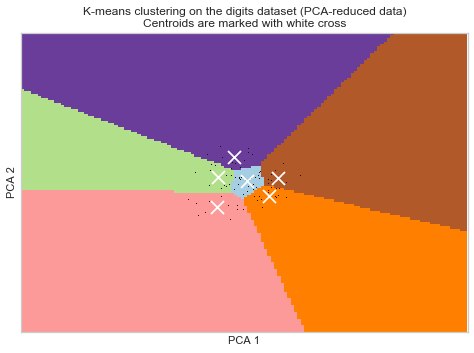

In [69]:
reduced_data = array
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.xlabel('PCA 1')
plt.ylabel('PCA 2') 
plt.show()

In [71]:
loss = []
for i in range(1,10):
    reduced_data = array
    kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
    kmeans.fit(reduced_data)
    loss.append(kmeans.inertia_)

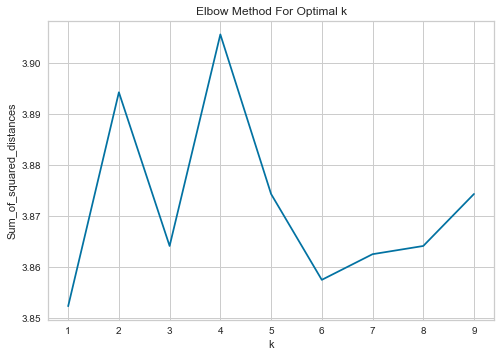

In [76]:
plt.plot(range(1,10), loss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()